# Context

Autoencoder to explore latent slow-wave-shape space

# Imports

In [5]:
from skimage import io
import skimage
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter, uniform_filter
import pickle

In [6]:
import imageio
from pathlib import Path

In [7]:
from PIL import Image
import os

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import gridspec
import pickle

In [9]:
import matplotlib.animation
from IPython.display import HTML
matplotlib.rcParams['animation.embed_limit'] = 2**128

### Import our custom utility methods

In [10]:
import sys
%reload_ext autoreload
%autoreload 2
sys.path.append('..')

from utils.visualization_tools import *
import utils.visualization_tools
from utils.data_transformations import *
import utils.data_transformations
from utils.diverse import *
import utils.diverse

## Load dataset

In [12]:
with open("../../../main_experiment/sparse_data/dataset.pkl", "rb") as f:
    dataset = pickle.load(f)
slow_wave_ids = list(dataset["sws"].keys())
print(len(slow_wave_ids))

iso = np.array([dataset["sws"][k]["iso"] for k in slow_wave_ids])
starts = np.array([dataset["sws"][k]["start"] for k in slow_wave_ids])
stops = np.array([dataset["sws"][k]["stop"] for k in slow_wave_ids])
width = np.array([dataset["sws"][k]["width"] for k in slow_wave_ids])
height = np.array([dataset["sws"][k]["height"] for k in slow_wave_ids])
gcamp = np.array([dataset["sws"][k]["gcamp_interpolated"] for k in slow_wave_ids])
hemo = np.array([dataset["sws"][k]["hemo_interpolated"] for k in slow_wave_ids])
#gcamp = np.array([dataset["sws"][k]["gcamp_mean_centered"] for k in slow_wave_ids])
#hemo = np.array([dataset["sws"][k]["hemo_mean_centered"] for k in slow_wave_ids])

3030


In [13]:
def stack_vectors(vectors):
    n_vectors = len(vectors)
    stacked_vectors = np.hstack(vectors)
    stacked_vectors = stacked_vectors.reshape([stacked_vectors.shape[0], n_vectors, 128])
    stacked_vectors = np.expand_dims(stacked_vectors, -1)
    return n_vectors, stacked_vectors

In [14]:
gcamp.shape

(3030, 128)

In [15]:
scale = np.vstack([height, width]).T
n_vectors, stacked_vectors = stack_vectors([gcamp])
#n_vectors, stacked_vectors = stack_vectors([interpolated, hemo_interpolated])

In [16]:
from sklearn.model_selection import train_test_split
random_state = 42
test_size=.2
vectors_train, vectors_test = train_test_split(stacked_vectors, test_size=test_size, random_state = random_state)
#vectors_train, vectors_test = train_test_split([interpolated], test_size=test_size, random_state = random_state)

scale_train, scale_test = train_test_split(scale, test_size=test_size, random_state = random_state)

# Autoencoder

In [17]:
from keras.layers import Dense, Input
from keras.layers import Conv2D, Flatten, Lambda
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.layers import Lambda, Input, Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Reshape, Concatenate
from keras.layers import Conv2DTranspose, UpSampling2D
import keras

from keras import backend as K
import tensorflow as tf

In [18]:
tf.compat.v1.disable_eager_execution()

In [19]:
variational_autoencoder = False

In [20]:
vectors_input = Input(shape=(n_vectors, 128, 1), name='encoder_input')
x1 = Conv2D(8, (1, 20), activation='relu', padding='same')(vectors_input)
x2 = MaxPooling2D((1, 2), padding='same')(x1)
x3 = Conv2D(16, (1, 10), activation='relu', padding='same')(x2)
x4 = MaxPooling2D((1, 2), padding='same')(x3)
x5 = Conv2D(30, (1, 5), activation='relu', padding='same')(x4)
x6 = Flatten()(x5)
x6 = Dense(256, activation='relu')(x6)

In [21]:
latent_layer = Dense(2, activation='relu',name='z_mean')(x6)
encoder = Model(vectors_input, latent_layer, name='encoder')
#encoder.summary()

In [22]:
latent_inputs = keras.Input(shape=(2,))
dx1 = Dense(256, activation='relu')(latent_inputs)
dx2 = Dense(np.prod(list(x5.shape)[1:]), activation='relu')(dx1)
dx3 = Reshape(list(x5.shape)[1:])(dx2)
dx3b = Conv2DTranspose(filters=30,kernel_size=(1,5),activation='relu',strides=(1,2),padding='same')(dx3)
dx4 = Conv2DTranspose(filters=16,kernel_size=(1,5),activation='relu',strides=(1,2),padding='same')(dx3b)
dx5 = Conv2DTranspose(filters=8,kernel_size=(1,10),activation='relu',strides=(1,1),padding='same')(dx4)
vectors_output = Conv2DTranspose(filters=1,kernel_size=(1,10),activation='relu',strides=(1,1),padding='same')(dx5)

decoder = Model(latent_inputs, vectors_output, name='decoder')
try:
    assert list(vectors_output.shape)[1:] == list(vectors_input.shape)[1:]
except:
    print("Output shape and input shape must be equal")
    print(vectors_input.shape)
    print(vectors_output.shape)

In [25]:
vectors_output.shape

TensorShape([None, 1, 128, 1])

In [24]:
list(x5.shape)[1:]

[1, 32, 30]

In [23]:
#autoencoder = keras.Model(vectors_input, vectors_output)
outputs = decoder(encoder([vectors_input]))
autoencoder = Model(inputs=vectors_input, outputs=outputs, name='autoencoder')
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [51]:
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 1, 128, 1)]       0         
_________________________________________________________________
encoder (Functional)         (None, 2)                 250424    
_________________________________________________________________
decoder (Functional)         (None, 1, 128, 1)         255803    
Total params: 506,227
Trainable params: 506,227
Non-trainable params: 0
_________________________________________________________________


In [52]:
autoencoder.fit(vectors_train, vectors_train, epochs=1,batch_size=64, verbose=0)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


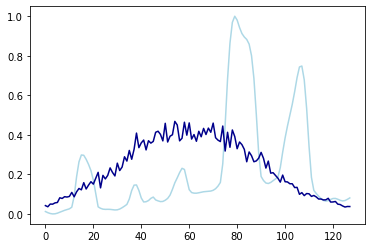

In [53]:
i = 200
res = autoencoder.predict(vectors_train[i:i+1])

plt.plot(vectors_train[i,0,:,0], c= "lightblue")
#plt.plot(vectors_train[2,1,:,0], c = "lightgray")

plt.plot(res[0,0,:,0], c = "darkblue")
#plt.plot(res[0,1,:,0], c= "darkblue")

In [29]:
vectors_output.shape

TensorShape([None, 1, 128, 1])

In [48]:
dx5.shape

TensorShape([None, 1, 128, 8])

In [49]:
dx4.shape

TensorShape([None, 1, 128, 16])

In [50]:
list(x5.shape)

[None, 1, 32, 32]

In [51]:
#x1.shape

In [52]:
vectors_input.shape

TensorShape([None, 1, 128, 1])

In [53]:
dx6.shape

NameError: name 'dx6' is not defined

In [ ]:
out.shape

In [ ]:
out.shape

In [ ]:
for i in range(3):
    x = Conv2DTranspose(filters=filters,kernel_size=kernel_size,activation='relu',strides=2,padding='same')(x)
    filters //= 2